# Multi-Action Synthetic Control Example

This Jupyter notebook is designed to be a simple, "user-friendly" tool to demonstrate the Multi-Action Synthetic Control (MA-SC) algorithm. 

The MS-SC algorithm is implented in the $\textbf{fill_tensor}$ method below. 

In Sections 1 and 2, using artificially generated data, we illustrate how to use the $\textbf{fill_tensor}$ method to generate counterfactuals for $\textit{each unit}$ under $\textit{each intervention}$ of interest (i.e., personalized interventions). 

We hope you find the method useful for your problems of interest. We have found MA-SC to product accurate counterfactual estimates across a wide vareity of fields including: econometric policy evaluation, web-scale A/B testing, sports, genetics. We hope you find it to be of use too for your problems of interest.

In [1]:
from scontrol2 import random_rct, diagnostic, fill_tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Section 1 - Generating Artificial Data from a Randomized Control Trial

### Explanation of Terms $N, I, T, T_0, r, \sigma$ 

We begin with generating artificial data for the purposes of the demonstration through the function random_rct. All the data can be captured through a 3-dimensional tensor, $\mathcal{M} \in \mathbb{R}^{N \times T \times I}$.

$N$ denotes the number of units we perform the experiments on. 

$I$ denotes the total number of intervention. Each unit $n \in N$ will recieve exactly one intervention, $i \in I$.

$T$ is the total number of time periods (i.e., total number of measurements) we perform the experiment for. 

$T_0$ is the number of pre-intervention periods. Note $1 < T_0 < T$.

$r$ denotes the "model complexity", i.e., the rank of the tensor $\mathcal{M}$. 

$\sigma$ is the level of noise added to each measurement, i.e., the variance parameter of mean zero Gaussian noise.

In [2]:
# Generate Artifical Data

# Number of Units
N = 10
# Number of Interventions
I = 4
# Number of Total Time Steps (Pre- and Post-Intervention)
T = 200
# Number of Pre-Intervention Time Steps
T0 = 100
# Model Complexity
rank = 3
# Noise in System
sigma = 0.2

rct_data = random_rct(N, I, T, T0, rank, sigma)

### Pre-Intervention & Post-Intervention Data (pre_df, post_df)

The rct_data object returned by calling the function $\textbf{random_rct}$ is comprised of two dataframes: pre_df and post_df.

pre_df is a 2-dimensional matrix, $\mathcal{M}^{\text{pre}} \in \mathbb{R}^{N \times T_0}$. It is measurements of all units before any experiments are performed.

post_df is a 2-dimensional matrix, $\mathcal{M}^{\text{post}} \in \mathbb{R}^{N \times (T-T_0)}$. It is the intervention that each unit $n \in N$ experienced (actually observed in reality) in the post-intevention phase. 

(Note not each unit in pre_df has to have experienced an intervention. Further, a unit can experience multiple interventions. The function $\textbf{fill_tensor}$ (the MA-SC algorithm) will work as is for both. For simplicity, we illustrate on artificial data, the case where each unit in the pre-intervention phase $n \in N$ receives exactly one intervention in the post-intervention phase.)

In [3]:
# Pre- and Post- Intervention Data
pre_df, post_df = rct_data

In [4]:
print(pre_df.shape)
pre_df.head()

(10, 102)


,unit,intervention,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,id_0,inter_0,-1.806156,1.326842,-0.001761,-1.531713,-2.249128,0.389611,-0.601277,-1.380035,...,0.765040,1.131046,-0.230008,3.515892,-3.532536,1.342478,1.265003,-1.614045,-0.588015,-0.878721
1,id_1,inter_0,-0.533444,-1.507023,0.012218,0.130216,1.001838,-0.583975,0.446869,1.007368,...,-0.217829,-0.850885,-1.046251,-0.549215,0.861674,-0.859623,-0.905199,0.544997,-0.199370,-0.006859
2,id_2,inter_0,-2.429068,-0.819657,-0.683394,-0.876846,-0.038059,0.047564,-0.218356,0.184970,...,-0.091968,-0.708335,-0.867433,2.223796,-1.766351,-0.123202,-1.209693,-1.120750,-0.915223,-0.879500
3,id_3,inter_0,0.603768,0.474955,0.074815,0.611276,0.590967,0.333205,0.092158,-0.251873,...,-0.241945,0.393471,0.519241,-1.145331,0.607956,0.194708,0.400153,0.296669,0.198646,0.522459
4,id_4,inter_0,0.595597,-3.497834,-0.272118,1.909710,4.386373,-1.172451,0.691947,3.805822,...,-1.612048,-2.167507,-0.969331,-4.468894,4.461245,-2.345109,-3.158030,1.995606,0.023639,0.865255


In [ ]:
print(post_df.shape)
post_df.head(10)

(10, 102)


,unit,intervention,t_100,t_101,t_102,t_103,t_104,t_105,t_106,t_107,...,t_190,t_191,t_192,t_193,t_194,t_195,t_196,t_197,t_198,t_199
0,id_0,inter_2,-0.055887,2.570472,-0.292026,0.648940,0.840749,0.293611,2.141268,1.828418,...,2.313534,2.062607,1.722109,1.567375,-0.239476,1.572287,3.479951,0.117062,-3.275528,-0.769469
1,id_1,inter_0,0.857314,0.518216,-1.922655,-1.097863,0.622607,-1.638012,-0.863918,-1.093014,...,0.209707,2.453424,-0.482867,0.534879,-0.484958,0.947863,0.009321,-1.659943,-0.003506,1.710060
2,id_2,inter_0,1.002783,0.679609,-2.243348,0.086443,0.043249,-2.053843,3.624356,2.045849,...,0.674974,0.104972,1.137282,2.175631,-0.936647,2.429785,1.637684,-0.739087,-1.888646,0.375025
3,id_3,inter_3,-0.889857,-0.406624,1.251182,0.850900,-0.641569,1.033967,0.313386,0.668876,...,-0.189537,-1.477992,-0.202428,-0.798954,0.276281,-0.660448,-0.394556,1.101263,0.293933,-1.252238
4,id_4,inter_3,1.997083,0.985345,-3.613141,-1.504983,0.773921,-2.482288,0.396737,-0.508344,...,0.393802,3.276676,-0.058963,1.971973,-0.914924,2.576896,-0.018420,-2.212487,-0.406850,2.504261
5,id_5,inter_1,0.853261,-0.430385,-1.581636,-0.295738,-0.110509,-1.483190,0.591971,0.065469,...,-0.356778,0.073397,-0.175657,0.781405,-0.402689,0.770916,-0.433430,-1.013277,0.151021,0.987513
6,id_6,inter_2,-0.280671,0.095937,0.938587,0.255114,-0.150882,0.404490,-0.110850,0.164700,...,-0.180274,-0.686351,0.260501,-0.235768,0.062428,-0.189478,-0.066803,0.805511,-0.205501,-0.022939
7,id_7,inter_2,-0.666131,-0.834648,1.090435,0.646498,-0.287582,0.272478,0.129846,-0.189510,...,-0.606375,-2.114152,-0.477227,-0.808163,-0.050502,-0.577855,-0.724504,0.358195,0.749387,-0.615077
8,id_8,inter_2,1.405279,-0.755886,-2.568218,-0.755174,-0.136430,-2.646627,0.429577,-0.615964,...,-1.067311,-0.042833,-0.962738,1.061833,-0.622336,0.976350,-1.691092,-1.837790,0.937173,1.760819
9,id_9,inter_0,-0.709564,-0.822058,1.489997,0.916337,-0.675658,1.160871,0.660468,0.462537,...,-0.561838,-2.812282,-0.299699,-0.786939,0.515275,-1.321580,-0.727171,1.440291,0.631488,-0.804715


## Section 2 - Diagnostic: Which Interventions can be reliably produce counterfactuals for?

In this section we show how to use our diagnostic tool method, termed $\textbf{diagnostic}$. 

$\textbf{diagnostic}$ is a function to assess if the counterfactual estimates produced are reliable. Recall, in reality, we do not get access to the counterfactual estimates. Hence, we need a test to see if any relationship we learn in the pre-intervention phase, will continue to reliably hold in the post-intervention phase. 

$\textbf{diagnostic}$ is an implementation of the "rank preservation" test, i.e., we check if the singualr values are not siginifacntly preturbed pre- and post- intervention. If they are not, then we can  safely use the counterfactual estimates produced for that intervention. 

The input to $\textbf{diagnostic}$ are the two pre- and post- intervention dataframes (pre_df, post_df). There is an optional parameter, $\textit{cum_energy} \in [0, 1]$ which denotes the threshold at which we cutoff the spectrum (i.e., choose the effective rank). This parameter is going to be application dependent. 

In [ ]:
diagnostic(pre_df, post_df, cum_energy=0.90)

,intervention,Pre Intervention Rank (90.0%),Post Intervention Rank (90.0%),Valid (90.0%)
0,inter_0,2.0,2.0,True
1,inter_1,1.0,1.0,True
2,inter_2,2.0,2.0,True
3,inter_3,1.0,2.0,False


## Section 3 - Producing Counterfactual Estimates: For Each Unit Under Each Intervention

In this section, we show how to use the $\textbf{fill_tensor}$ method to produce personalized interventions for each unit. 

The input to $\textbf{fill_tensor}$ are the two pre- and post- intervention dataframes. 

The key parameter to the method is: $\textit{cumulative_energy} \in [0, 100]$, which decides the number of prinicpal components to retain when performing Principal Component Regression, when we learn a linear coefficient. In essence, we find the minimum of principal components required such that the percentage of the spectral energy retained is above the given parameter. 

The output of $\textbf{fill_tensor}$ is a order-3 tensor (flattended), $\hat{\mathcal{M}}^{\text{Counterfactual}}\in \mathbb{R}^{N \times (T - T_0) \times I}$, termed $\textit{df_output}$. This contains the counterfactual estiamtes for every unit $n \in [N]$ and for each intervention $i \in [I]$, over the entire post-intervention period, $T - T_0$. This is the desired output!

In [ ]:
df_output = fill_tensor(pre_df, post_df, cum_energy=0.90)
df_output.head(10)

,unit,intervention,t_100,t_101,t_102,t_103,t_104,t_105,t_106,t_107,...,t_190,t_191,t_192,t_193,t_194,t_195,t_196,t_197,t_198,t_199
0,id_0,inter_0,-0.232787,-0.303249,0.464127,1.946514,-1.092683,0.155210,5.757587,4.001238,...,0.210785,-4.479778,1.726301,1.493953,-0.238671,0.984402,1.489543,1.935039,-1.858141,-2.023884
1,id_0,inter_1,0.739856,-0.373184,-1.371424,-0.256432,-0.095821,-1.286062,0.513293,0.056768,...,-0.309360,0.063642,-0.152310,0.677550,-0.349168,0.668455,-0.375824,-0.878604,0.130949,0.856264
2,id_0,inter_2,0.004269,2.598090,-0.337314,0.448698,0.850556,0.463269,1.798884,1.729085,...,2.352901,2.498081,1.758892,1.512773,-0.125776,1.454505,3.481602,0.167205,-3.207679,-0.693333
3,id_0,inter_3,0.025998,-0.023989,0.360317,-0.224328,0.346996,0.049537,-0.551396,-0.508909,...,0.021099,0.063067,0.258913,-0.064841,0.137277,-0.520288,0.457082,-0.159865,-0.133205,0.187469
4,id_1,inter_0,0.932946,0.779815,-2.034203,-1.448929,0.895856,-1.643767,-1.752828,-1.537344,...,0.376338,3.629468,-0.427771,0.500389,-0.526851,1.103965,0.133284,-2.064227,-0.026998,1.800953
5,id_1,inter_1,0.059457,-0.029990,-0.110211,-0.020608,-0.007700,-0.103351,0.041250,0.004562,...,-0.024861,0.005114,-0.012240,0.054450,-0.028060,0.053719,-0.030202,-0.070607,0.010523,0.068812
6,id_1,inter_2,-0.584468,-0.602676,1.184360,0.221653,-0.251325,0.836357,-0.676495,-0.311721,...,-0.417311,-1.028272,-0.227356,-0.928120,0.250592,-0.850905,-0.543368,0.687097,0.703189,-0.473381
7,id_1,inter_3,1.117915,0.532466,-1.811157,-0.948694,0.608058,-1.347046,-0.066731,-0.545211,...,0.228729,1.844790,0.101749,1.056890,-0.434734,1.155081,0.227005,-1.306505,-0.294119,1.482186
8,id_2,inter_0,1.021809,0.745415,-2.271408,-0.001868,0.111986,-2.055291,3.400749,1.934076,...,0.716890,0.400809,1.151142,2.166955,-0.947185,2.469053,1.668868,-0.840786,-1.894556,0.397889
9,id_2,inter_1,0.836257,-0.421809,-1.550117,-0.289845,-0.108307,-1.453633,0.580174,0.064165,...,-0.349668,0.071934,-0.172156,0.765833,-0.394664,0.755553,-0.424793,-0.993085,0.148011,0.967834


inter_2


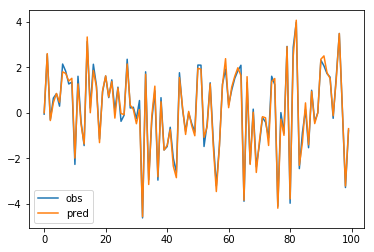

In [ ]:
for unit in ["id_" + str(i) for i in range(5)]:

    inter_obs = str(post_df[post_df["unit"] == unit]['intervention'].values[0])
    print(inter_obs)

    y = post_df.loc[(post_df.unit==unit) & (post_df.intervention==inter_obs)].drop(columns=['unit', 'intervention']).values
    y_hat = df_output.loc[(df_output.unit==unit) & (df_output.intervention==inter_obs)].drop(columns=['unit', 'intervention']).values

    plt.figure()
    plt.plot(y.flatten(), label='obs')
    plt.plot(y_hat.flatten(), label='pred')
    plt.legend(loc='best')
    plt.show()